<h1 style="font-size:3rem;color:orange;">Random Forest Test 2</h1>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import math
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

In [2]:
math_df = pd.read_csv('../student_data/student-mat.csv')

## Target G3 using all factors

In [3]:
X = math_df.drop(columns=['G3'])
y = math_df['G3']

In [4]:
# Now encode values that ARE NOT ALREADY numeric.
# Binary cols have only two categories (school, sex, address, etc) ~ use LabelEncoder
# Nominal cols have more 2 categories that have NO  ORDER (Mjob, Fjob) ~ use One-Hot Encoding
# Numeric cols (age, Medu, absences) are already numbers ~ No encoding needed

binary_cols = ['school', 'sex', 'address', 'famsize', 'Pstatus', 
               'schoolsup', 'famsup', 'paid', 'activities', 
               'nursery', 'higher', 'internet', 'romantic']
nominal_cols = ['Mjob', 'Fjob', 'reason', 'guardian']

for col in binary_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

X = pd.get_dummies(X, columns=nominal_cols, drop_first=True)


# Split data (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# shapes of splitted data, sizes of X_train and y_train should be the same, same thing with tests
print(f"X_train: {X_train.shape}\n")
print(f"X_test: {X_test.shape}\n")
print(f"y_train: {y_train.shape}\n")
print(f"y_test: {y_test.shape}")

X_train: (316, 41)

X_test: (79, 41)

y_train: (316,)

y_test: (79,)


In [6]:
def train_random_forest(X_train, X_test, y_train, y_test, n_estimators, max_depth=None):
    """
    Simple Random Forest Regressor
    """
    print("=" * 50)
    print("RANDOM FOREST REGRESSOR WITHOUT G1 AND G2")
    print("=" * 50)
    
    # Create and train model
    rf_model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=42
    )
    
    rf_model.fit(X_train, y_train)
    
    # Predictions
    y_pred_train = rf_model.predict(X_train)
    y_pred_test = rf_model.predict(X_test)
    
    # RMSE
    rmse_train = math.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = math.sqrt(mean_squared_error(y_test, y_pred_test))

    # MAE
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)

    # R²
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    
    # Print metrics
    print(f"Training R²: {r2_train:.4f}")
    print(f"Testing R²: {r2_test:.4f}")
    print(f"Training MAE: {mae_train:.4f}")
    print(f"Testing MAE: {mae_test:.4f}")
    print(f"Training RMSE: {rmse_train:.4f}")
    print(f"Testing RMSE: {rmse_test:.4f}")
    
    # Cross-validation
    cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='r2')
    print(f"Cross-validation R² scores: {cv_scores}")
    print(f"Mean CV R²: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    
    # Factor importance (optional but useful)
    factor_importance = (
        pd.DataFrame({
            'factor': X_train.columns,
            'importance': rf_model.feature_importances_
        })
        .sort_values('importance', ascending=False)
    )
    
    print(f"\nTop 10 most important factors:")
    print(factor_importance.head(10).to_string(index=False))
    
    return rf_model, y_pred_test, factor_importance


rf_model, rf_predictions, rf_importance = train_random_forest(
    X_train, X_test, y_train, y_test,
    100, max_depth=10
)


RANDOM FOREST REGRESSOR WITHOUT G1 AND G2
Training R²: 0.9832
Testing R²: 0.8196
Training MAE: 0.3614
Testing MAE: 1.1664
Training RMSE: 0.5938
Testing RMSE: 1.9233
Cross-validation R² scores: [0.903823   0.93546338 0.92599106 0.87237406 0.88665126]
Mean CV R²: 0.9049 (+/- 0.0471)

Top 10 most important factors:
     factor  importance
         G2    0.793172
   absences    0.110128
reason_home    0.021002
        age    0.011095
         G1    0.006282
     health    0.005451
     famrel    0.004511
      goout    0.003967
 activities    0.003907
  studytime    0.003507


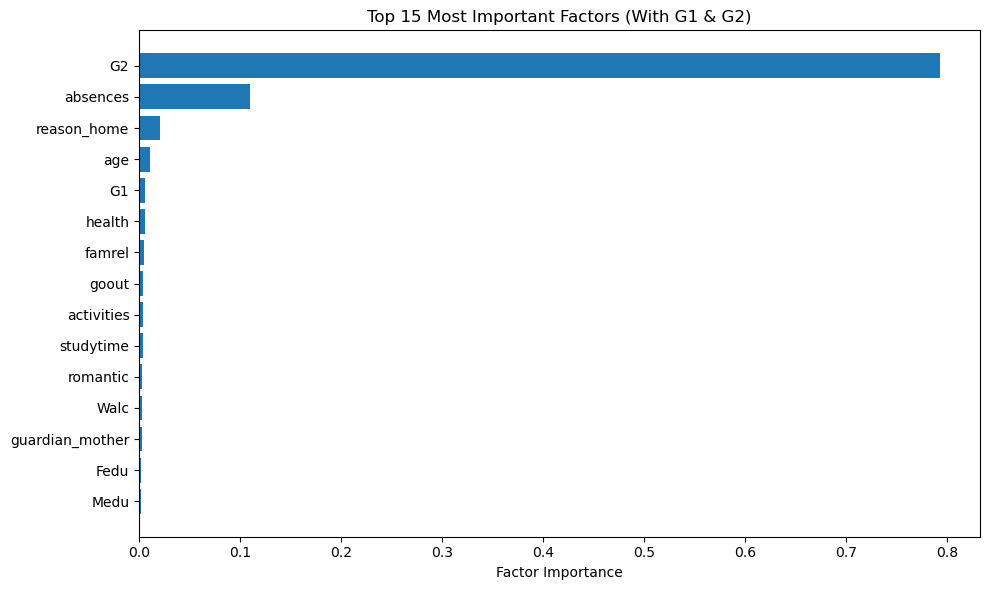

In [7]:
def plot_factor_importance(factor_importance, top_n=15):
    """
    Plot top N important features
    """
    top_factors = factor_importance.head(top_n)
    
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(top_factors)), top_factors['importance'])
    plt.yticks(range(len(top_factors)), top_factors['factor'])
    plt.xlabel('Factor Importance')
    plt.title(f'Top {top_n} Most Important Factors (With G1 & G2)')
    plt.gca().invert_yaxis()  # Most important at top
    plt.tight_layout()
    plt.show()

# Use it
plot_factor_importance(rf_importance, top_n=15)